<a href="https://colab.research.google.com/github/ZEBAAFROZ/Visual_Question_Answer/blob/main/GIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/huggingface/transformers/blob/main/src/transformers/models/git/modeling_git.py
https://huggingface.co/microsoft/git-base-textvqa

In [1]:
!pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00


In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from huggingface_hub import hf_hub_download
from PIL import Image

In [9]:
import torch

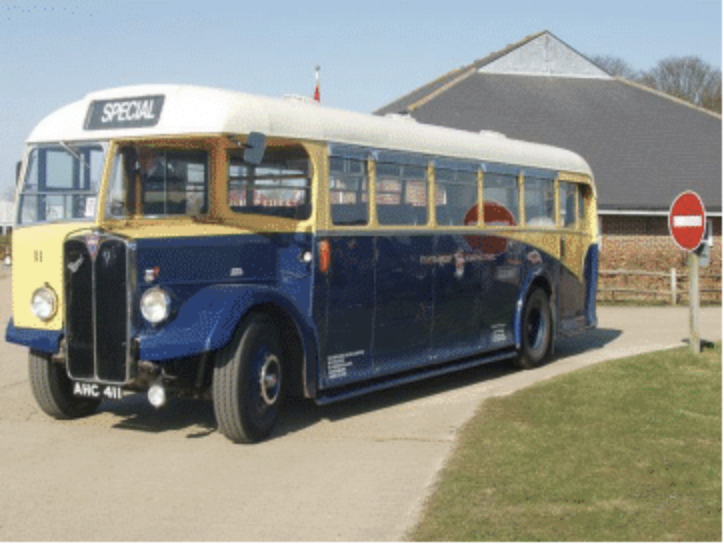

In [3]:
# load the image we will test GIT on
file_path = hf_hub_download(repo_id="nielsr/textvqa-sample", filename="bus.png", repo_type="dataset")
image = Image.open(file_path).convert("RGB")
image

In [4]:
# load necessary components: the processor and the model
processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa")

In [5]:
class GIT_VQA:
    """Custom implementation of the GIT model for Visual Question Answering (VQA) tasks."""

    def __init__(self, model, processor):
        """Initializes the model and the processor."""
        self.model = model
        self.processor = processor
        return


    def preprocess(self, image, question):
        """Preprocesses the inputs: image, question"""
        # process the image to get pixel values
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values

        # process the question to get input IDs, but do not add special tokens
        input_ids = self.processor(text=question, add_special_tokens=False).input_ids

        # add the CLS token at the beginning of the input_ids and format for model input
        input_ids = [self.processor.tokenizer.cls_token_id] + input_ids
        input_ids = torch.tensor(input_ids).unsqueeze(0)

        return pixel_values, input_ids


    def generate(self, pixel_values, input_ids):
        """Generates the output from the preprocessed inputs."""

        # generate output using the model with a maximum length of 50 tokens
        outputs = self.model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
        return outputs


    def postprocess(self, outputs):
        """Post-processes the output generated by the model."""

        # decode the output, ignoring special tokens
        answer = self.processor.batch_decode(outputs, skip_special_tokens=True)
        return answer


    def get_answer(self, image, question):
        """Returns human friendly answer to a question"""

        # preprocess
        pixel_values, input_ids = self.preprocess(image, question)
        # generate output
        outputs = self.generate(pixel_values, input_ids)
        # post-process
        answer = self.postprocess(outputs)
        return answer

In [6]:
# create a GIT instance
git_vqa = GIT_VQA(model=model, processor=processor)

In [10]:
# sample question 1
question = "what does the front of the bus say at the top?"
answer = git_vqa.get_answer(image, question)
print(answer)

['what does the front of the bus say at the top? special']


In [11]:
# sample question 2
question = "what are all the colors present on the bus?"
answer = git_vqa.get_answer(image, question)
print(answer)

['what are all the colors present on the bus? unanswerable']


In [12]:
# sample question 3
question = "How many wheels you see in the bus?"
answer = git_vqa.get_answer(image, question)
print(answer)

['how many wheels you see in the bus? 500']
